In [1]:
# basic
import os
import warnings
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
# pre processing
from sklearn import preprocessing as pre
# NN
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import MSELoss
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
# val and plot
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    explained_variance_score,
    mean_absolute_percentage_error
)
from loguru import logger as log
# plot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from torch_geometric.data import DataLoader
from torch_geometric.data import Batch
from torch_geometric.data import Data
from torchviz import make_dot
from tqdm.notebook import trange  # opcional, pra barra de progresso

from torch_geometric.nn import SAGEConv, LEConv, GlobalAttention
from torch_geometric.data import Batch

warnings.filterwarnings("ignore")
import networkx as nx

In [2]:
import torch_geometric.nn as gnn 

In [3]:
# set seed
SEED = 1345
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(SEED)
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.16f}'.format)

In [4]:
def load_dataset(fpath):
    # Load the StaticGraphTemporalSignal object from the file
    with open(fpath, 'rb') as f:
        loaded_temporal_signal = pickle.load(f)
    return loaded_temporal_signal

In [5]:
c = 51

In [7]:
train_dataset = load_dataset(f'dataset_train_{c}_time.pkl')
test_dataset  = load_dataset(f'dataset_test_{c}_time.pkl')

In [9]:
datas_test = test_dataset.copy()

100 200
200 300
(100,)
300 400
(100,)
400 500
(100,)


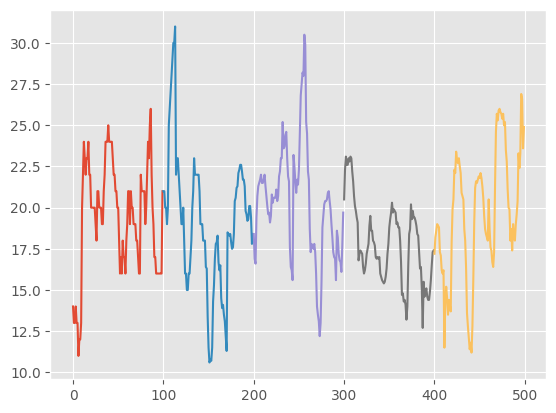

In [10]:
idx = 0
size_x = datas_test[idx].x[25,].shape[0]
size_y = datas_test[idx].y[25,].shape[0]
plt.plot(np.arange(0, size_x), datas_test[idx].x[25,])
plt.plot(np.arange(size_x, size_x + size_y), datas_test[idx].y[25,])
size_y = size_x + size_y
print(size_x, size_y)

for i in range(3):
    idx += 100
    if idx % 100 == 0:
        idx -= 1
    size_x += 100
    size_y += 100 
    print(size_x, size_y)
    print(np.arange(size_x, size_y).shape)
    plt.plot(np.arange(size_x, size_y), datas_test[idx].y[25,])

plt.show()

In [11]:
# dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [18]:
test_loader.dataset[0].y.shape

torch.Size([51, 100])

100 200
200 300
(100,)
300 400
(100,)
400 500
(100,)


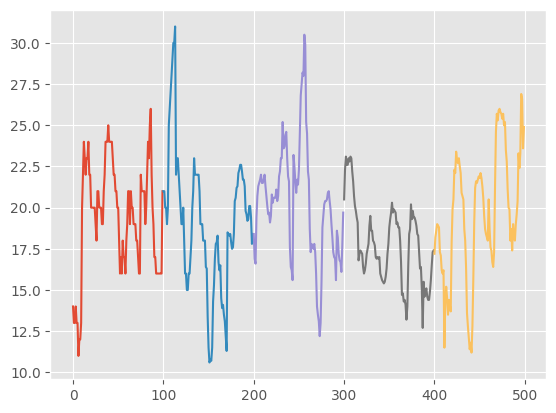

In [19]:
idx = 0
size_x = test_loader.dataset[idx].x[25,:].shape[0]
size_y = test_loader.dataset[idx].y[25,:].shape[0]
plt.plot(np.arange(0, size_x), test_loader.dataset[idx].x[25,])
plt.plot(np.arange(size_x, size_x + size_y), test_loader.dataset[idx].y[25,])
size_y = size_x + size_y
print(size_x, size_y)

for i in range(3):
    idx += 100
    if idx % 100 == 0:
        idx -= 1
    size_x += 100
    size_y += 100 
    print(size_x, size_y)
    print(np.arange(size_x, size_y).shape)
    plt.plot(np.arange(size_x, size_y), test_loader.dataset[idx].y[25,:])

plt.show()

In [ ]:
#  

In [20]:
device = 'cuda'
device

'cuda'

In [21]:
class SimpleGraphModel(nn.Module):
    def __init__(self, node_features, hidden_size=64, horizon=100, num_targets=3):
        super().__init__()
        # GCN: uma única camada
        self.conv1 = gnn.ChebConv(in_channels=node_features, 
                                      out_channels=hidden_size, 
                                      K=1)

        # Linear final para previsão
        self.linear = nn.Linear(hidden_size, num_targets * horizon)

        self.horizon = horizon
        self.num_targets = num_targets

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GCN
        x = self.conv1(x, edge_index).relu()

        # Pooling global por grafo no batch
        #x = global_mean_pool(x, batch)  # [batch_size, hidden_size]

        # Camada final de previsão
        x = self.linear(x)  # [batch_size, num_targets * horizon]

        #print(f"x: {x.shape}")
        # Reformatar saída
        #x = x.view(-1, self.horizon)  # [batch_size * num_targets, horizon]

        return x

In [22]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        #print(out.shape, batch.y.shape)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


def plot_predictions(model, loader, device, num_plots=3):
    model.eval()
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 3 * num_plots))
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_plots:
                break
            batch = batch.to(device)
            out = model(batch)  # Shape: [batch_size * num_targets, horizon]
            
            # Reformatar para [batch_size, num_targets, horizon]
            out = out.view(-1, model.num_targets, model.horizon)
            true = batch.y.view(-1, model.num_targets, model.horizon)
            
            # Pegar o primeiro grafo do batch
            true = true[0].cpu().numpy()  # Shape: [num_targets, horizon]
            pred = out[0].cpu().numpy()
            
            for target in range(true.shape[0]):
                axes[target].plot(true[target], label='True', color='blue')
                axes[target].plot(pred[target], label='Pred', color='red', linestyle='--')
                axes[target].set_title(f'Target {target + 1}')
                axes[target].legend()
    plt.tight_layout()
    plt.show()

In [23]:
model = SimpleGraphModel(
    node_features=100,  # conforme seu x=[12, 100]
    horizon=100,
    num_targets=1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

In [24]:
# Treinamento
for epoch in range(1, 10):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss = test(model, test_loader, criterion, device)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        #plot_predictions(model, test_loader, device, num_plots=3)

In [25]:
# stop

In [42]:
# def get_predictions(model, loader, device):
#     model.eval()
#     predictions = []
#     true_values = []
    
#     with torch.no_grad():
#         for batch in loader:
#             batch = batch.to(device)
#             out = model(batch)  # Shape: [batch_size * num_targets, horizon]
            
#             # Reformata para [batch_size, num_targets, horizon]
#             #out = out.view(-1, model.num_targets, model.horizon)
#             #y_true = batch.y.view(-1, model.num_targets, model.horizon)
#             y_true = batch.y
            
#             print(f"y_true: {y_true.shape}")
            
#             predictions.append(out.cpu().numpy())
#             true_values.append(y_true.cpu().numpy())
    
#     # Concatena todos os batches
#     predictions = np.concatenate(predictions, axis=0)  # Shape: [total_samples, num_targets, horizon]
#     true_values = np.concatenate(true_values, axis=0)
    
#     return predictions, true_values

# # Uso:
# predictions, y_trues = get_predictions(model, test_loader, device)
# print("Predictions shape:", predictions.shape)  # Ex: (100, 3, 100)

y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: torch.Size([51, 100])
y_true: to

In [44]:
def get_predictions(model, loader, device):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)     # [51, 100]
            y_true = batch.y       # [51, 100]

            preds.append(out.cpu().numpy())
            trues.append(y_true.cpu().numpy())

    # stack → mantém eixos [janelas, nós, horizonte]
    preds = np.stack(preds, axis=0)
    trues = np.stack(trues, axis=0)

    print(f"Predictions shape: {preds.shape}")
    print(f"True values shape: {trues.shape}")

    return preds, trues

In [45]:
predictions, y_trues = get_predictions(model, test_loader, device)

Predictions shape: (300, 51, 100)
True values shape: (300, 51, 100)


In [46]:
y_pred_src = predictions.copy()
y_true_src = y_trues.copy()
y_pred_src.shape, y_true_src.shape

((300, 51, 100), (300, 51, 100))

In [47]:
y_pred_n.shape

(51, 300, 100)

In [48]:
g = nx.read_graphml("../grafo.graphml")

#A = nx.adjacency_matrix(g)
nodes = sorted(g.nodes())  # ou outra lista ordenada de nós

In [49]:
nodes

['Auckland_Aerodrome',
 'Campbell_Island',
 'Cape_Campbell',
 'Cape_Reinga',
 'Castlepoint_NZCPX',
 'Chatham_Island',
 'Christchurch_Aerodrome',
 'Dunedin_Aerodrome',
 'Enderby_Island',
 'Farewell_Spit',
 'Gisborne_Aerodrome',
 'Haast_NZHTX',
 'Hamilton_Aerodrome',
 'Hawera_NZHAX',
 'Hicks_Bay',
 'Hokitika_Aerodrome',
 'Invercargill_NZNVA',
 'Kaikoura_NZKIX',
 'Kaitaia_Aerodrome',
 'Kerikeri_Aerodrome',
 'Le_Bons',
 'Mahia_NZMHX',
 'Milford_Sound',
 'Mokohinau_Island',
 'Mt_Cook',
 'Napier_Aerodrome',
 'Nelson_Aerodrome',
 'New_Plymouth',
 'Ngawi_NZNWX',
 'Nugget_Point',
 'Oamaru_Aerodrome',
 'Palmerston_N',
 'Paraparaumu_Aerodrome',
 'Port_Taharoa',
 'Puysegur_Point',
 'Queenstown_Aerodrome',
 'Raoul_Island',
 'Secretary_Island',
 'South_West',
 'Stephens_Island',
 'Takapau_Plains',
 'Tara_Hills',
 'Taupo_Aerodrome',
 'Tauranga_Aerodrome',
 'Timaru_Airport',
 'Waiouru_Aerodrome',
 'Wellington_Aerodrome',
 'Westport_Aerodrome',
 'Whanganui_Aerodrome',
 'Whangarei_Aerodrome',
 'Whitiang

In [50]:
 y_true_src.shape, y_true_res.shape

((300, 51, 100), (15300, 100))

In [52]:
y_true_src.shape

(300, 51, 100)

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


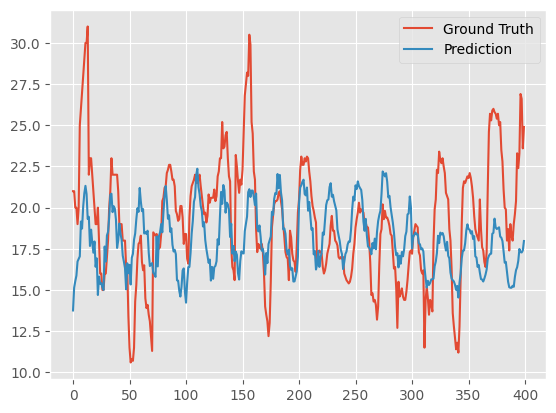

In [54]:
idx = 0
node = 25
ytrues = []
ypreds = []

for i in range(4):
#for i in [100, 200, 300]:
    print(f"shape idx: {idx}")
    y_true = y_true_src[idx, node,:].tolist()
    y_pred = y_pred_src[idx, node,:].tolist()
    
    ytrues.extend(y_true)
    ypreds.extend(y_pred)

    idx += 100
    if idx % 100 == 0:
        idx -= 1
        
plt.plot(ytrues, label="Ground Truth")
plt.plot(ypreds, label="Prediction")
plt.legend()
plt.show()

In [39]:
g = nx.read_graphml("../grafo.graphml")

#A = nx.adjacency_matrix(g)
nodes = sorted(g.nodes())  # ou outra lista ordenada de nós

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


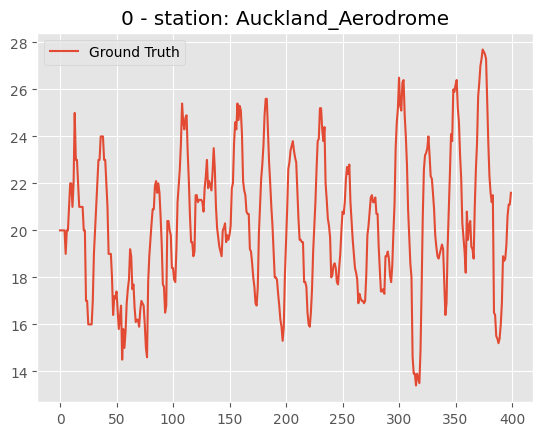

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


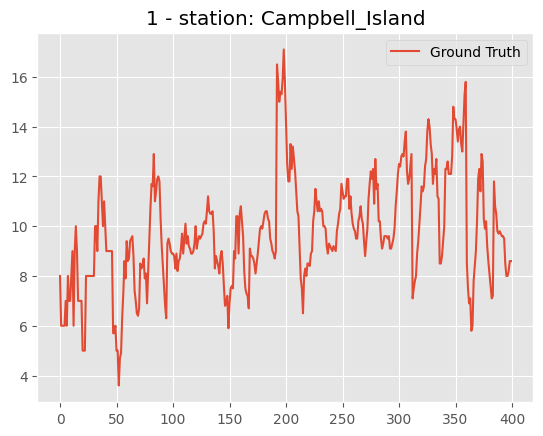

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


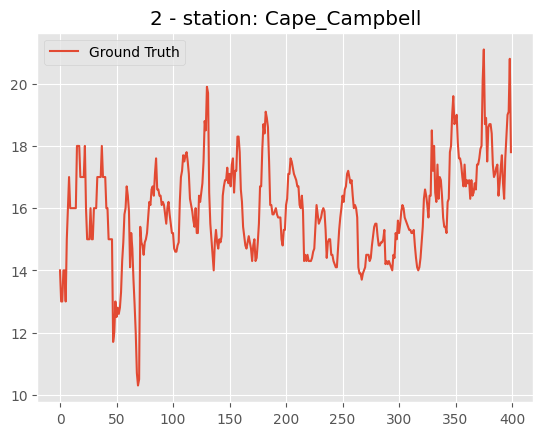

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


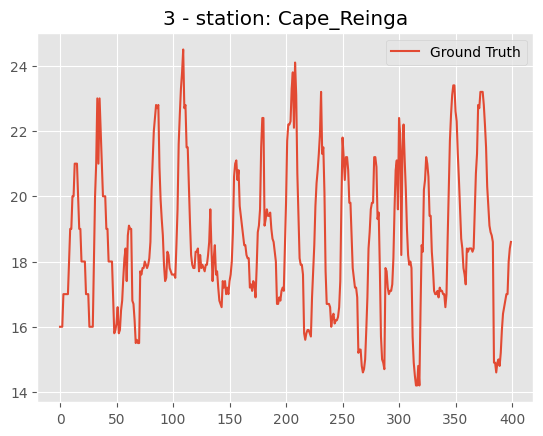

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


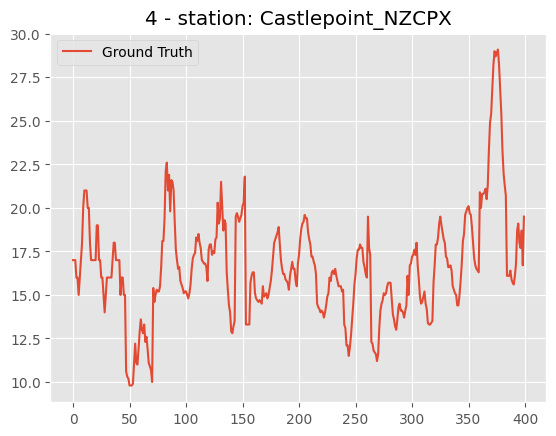

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


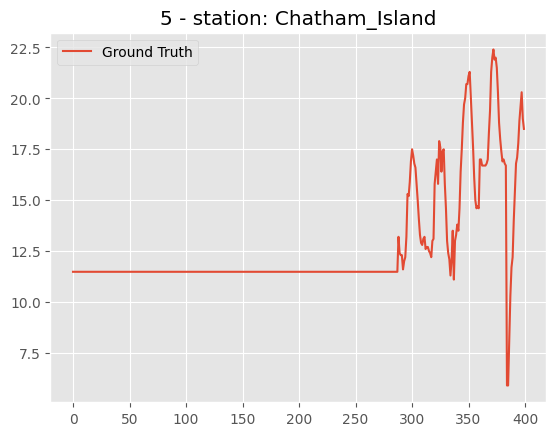

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


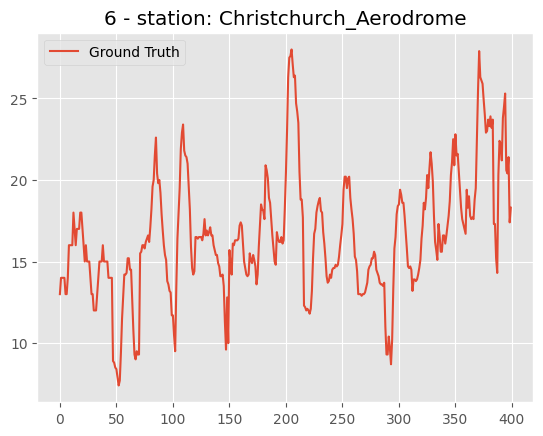

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


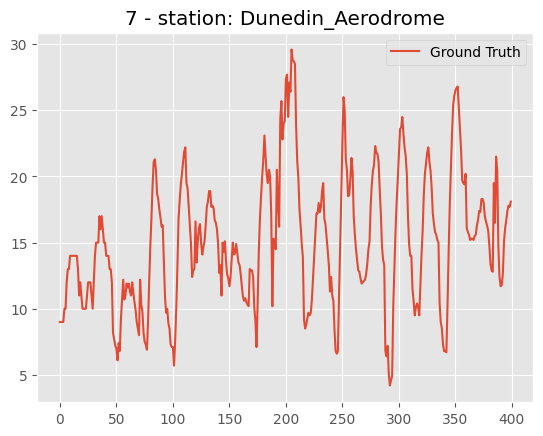

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


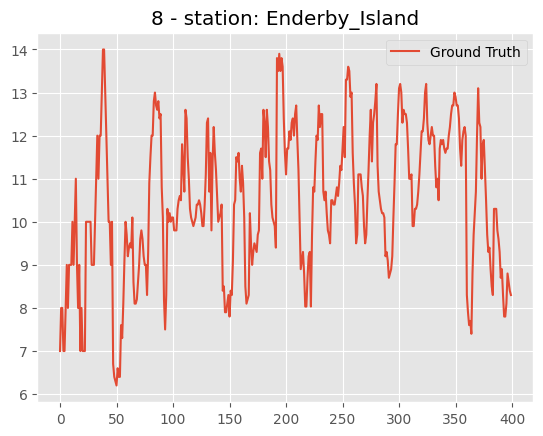

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


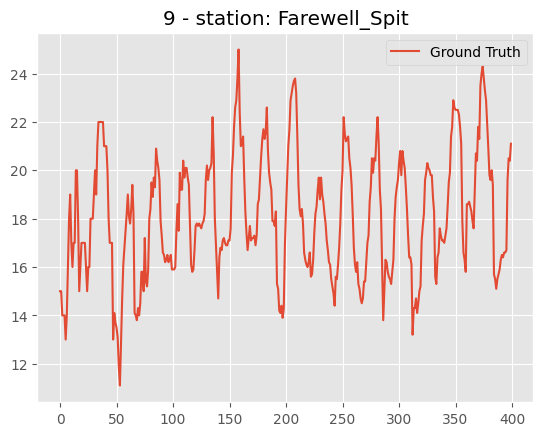

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


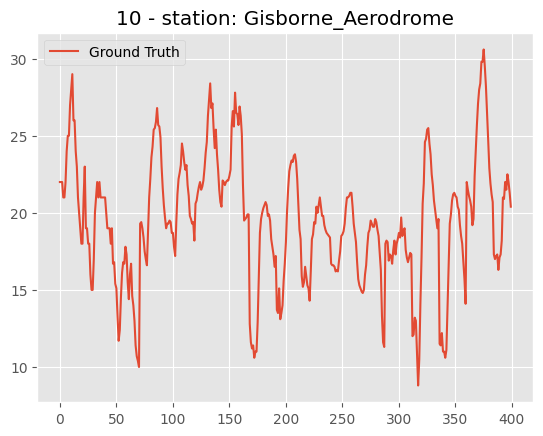

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


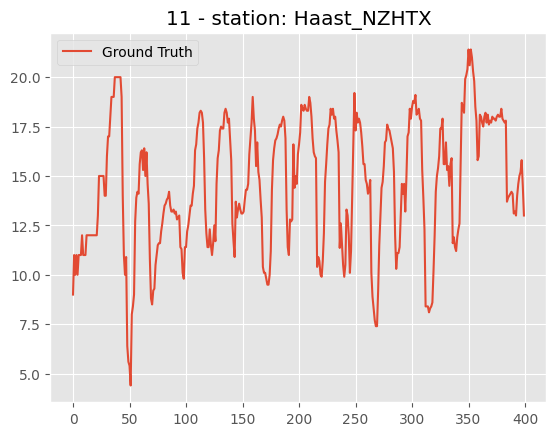

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


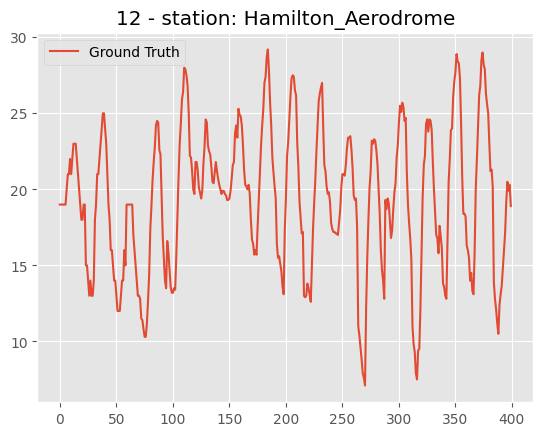

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


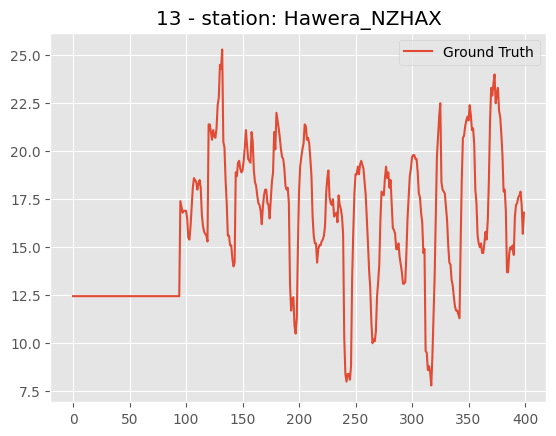

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


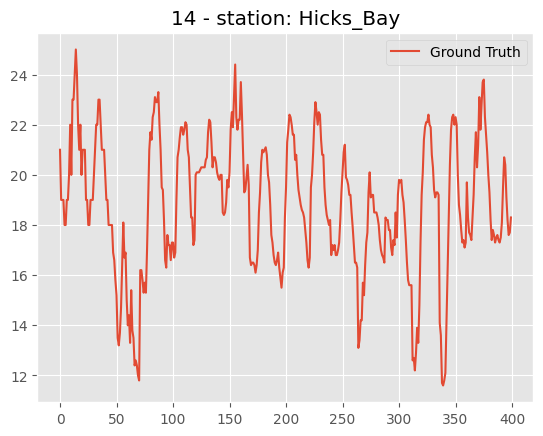

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


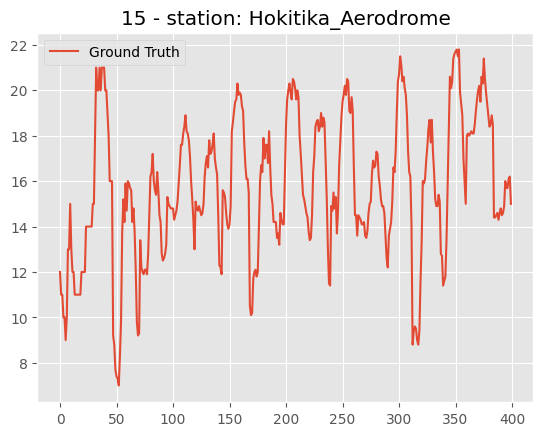

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


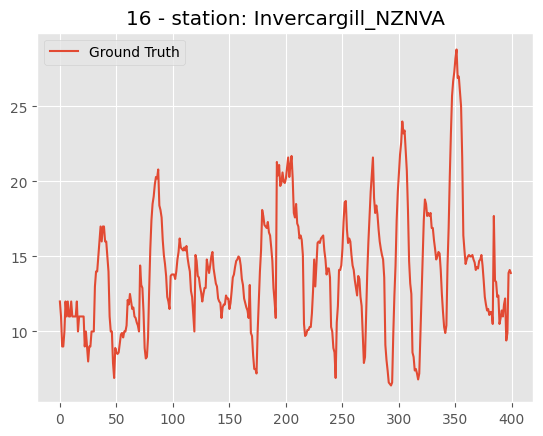

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


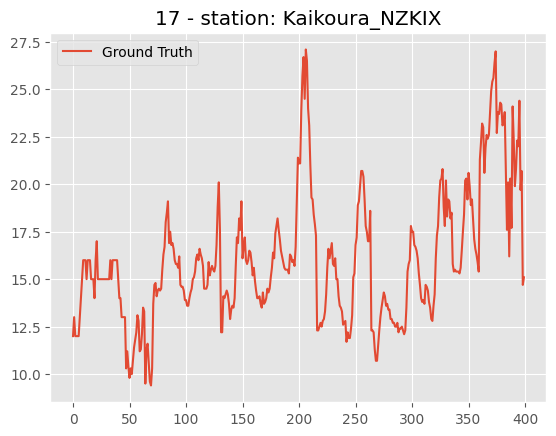

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


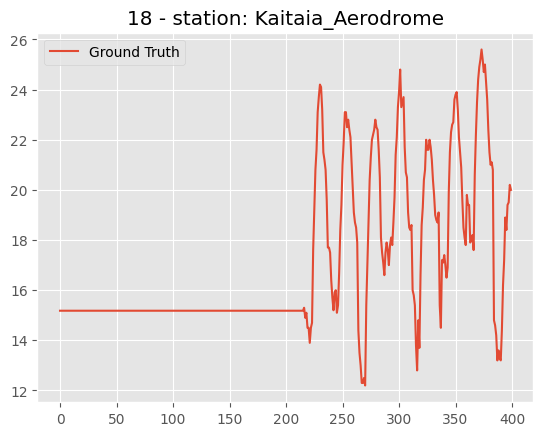

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


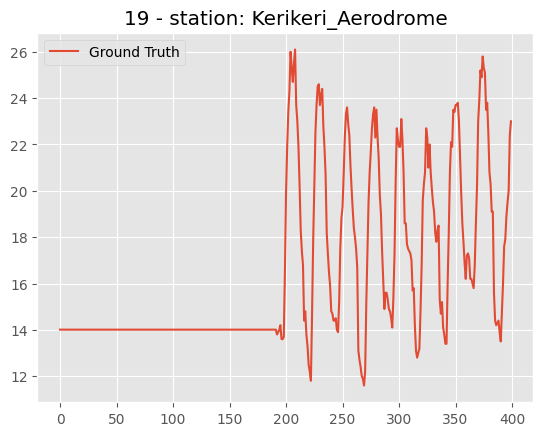

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


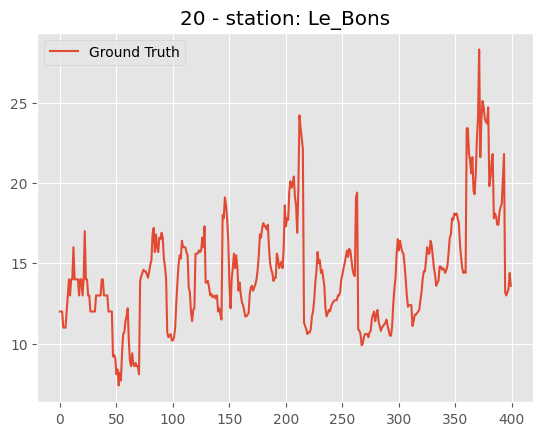

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


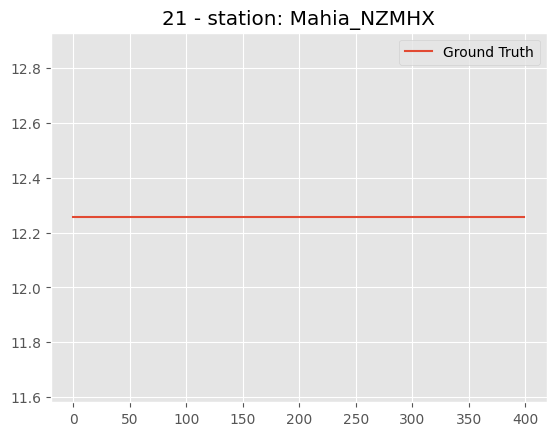

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


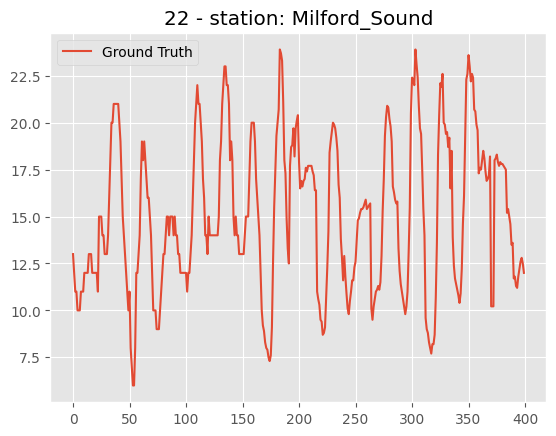

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


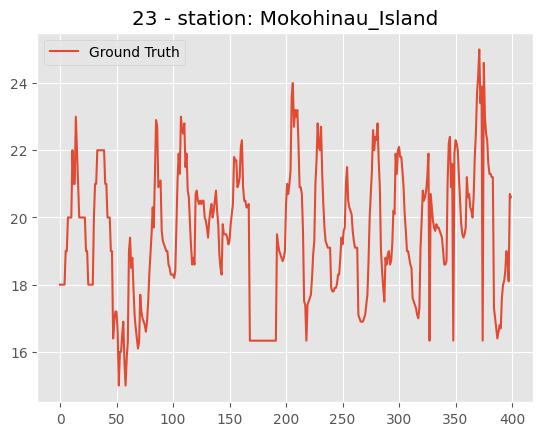

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


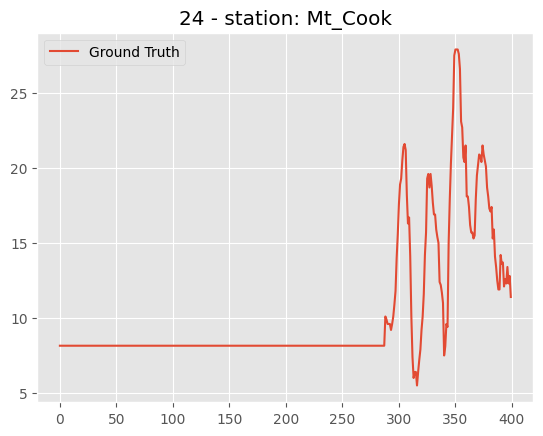

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


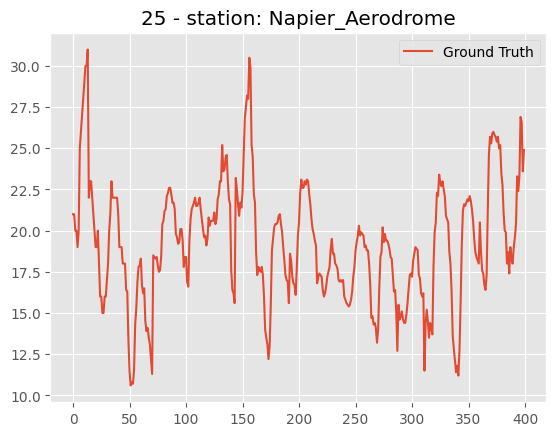

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


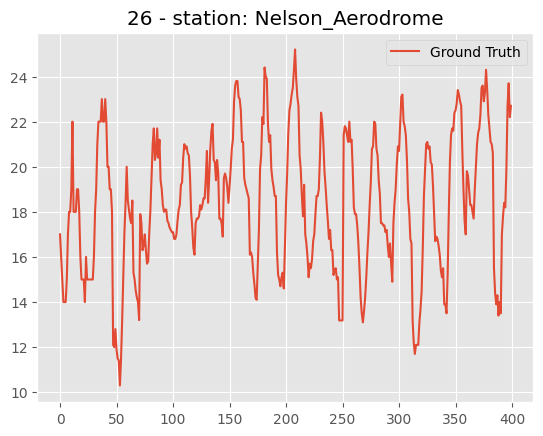

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


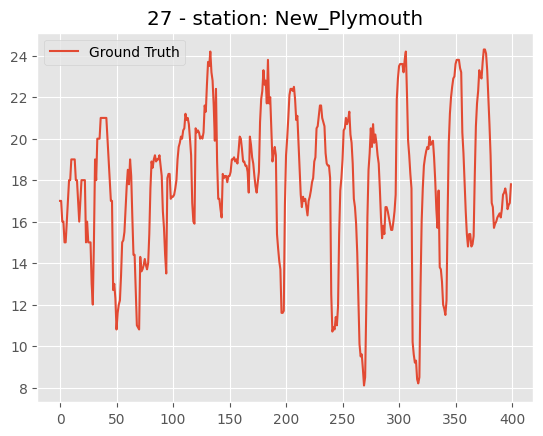

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


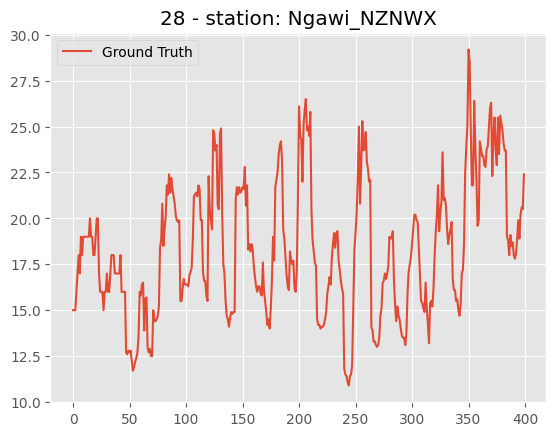

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


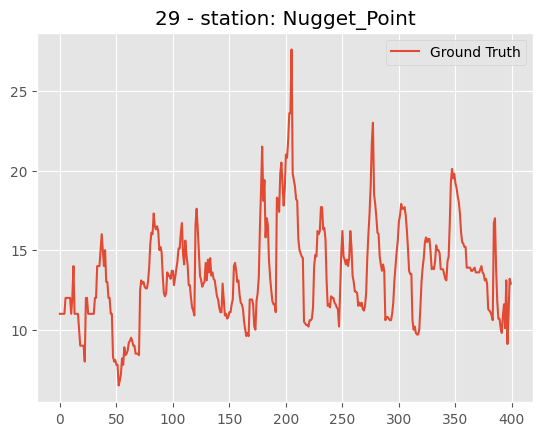

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


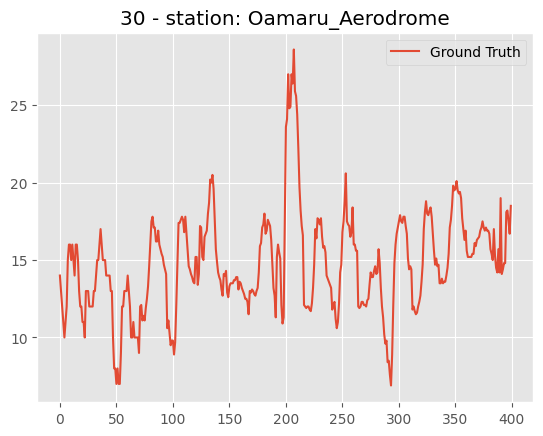

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


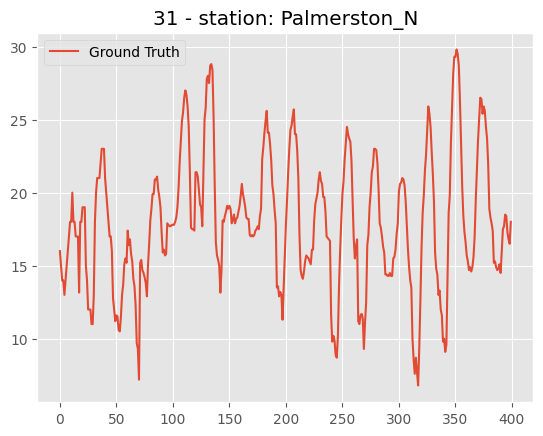

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


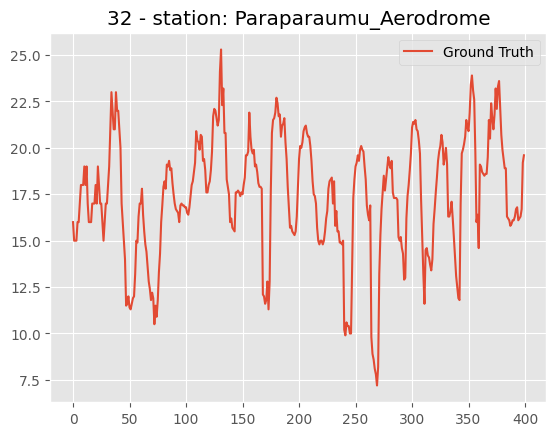

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


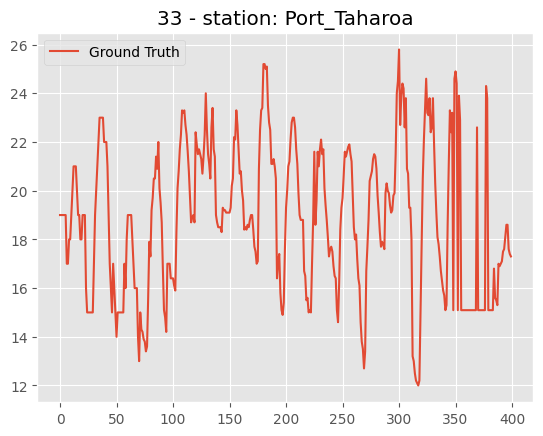

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


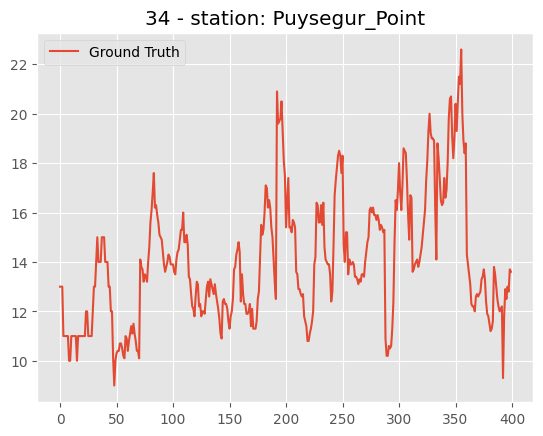

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


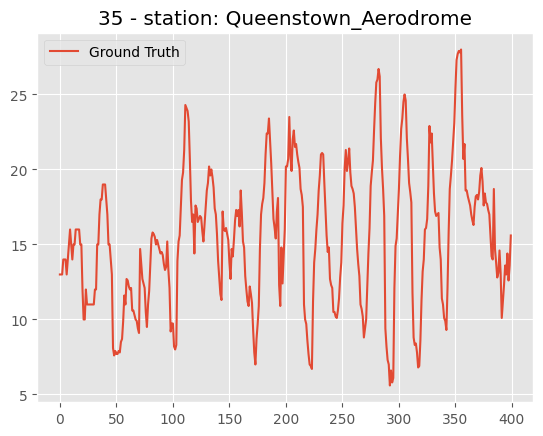

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


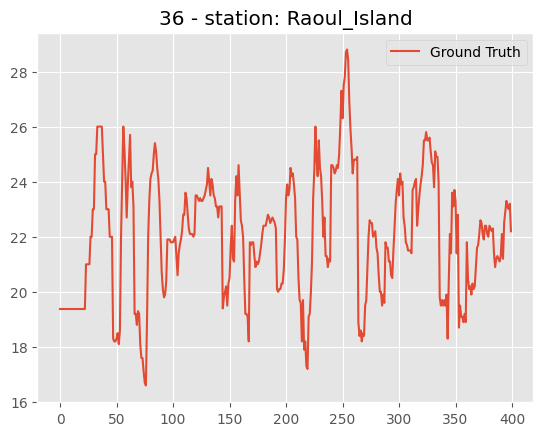

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


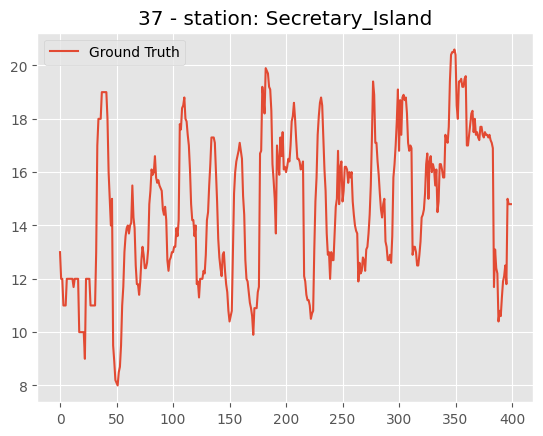

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


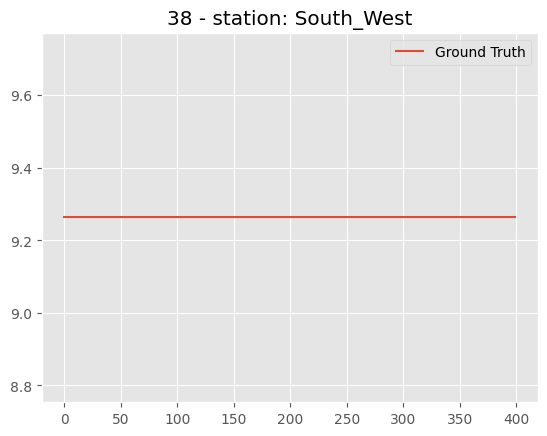

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


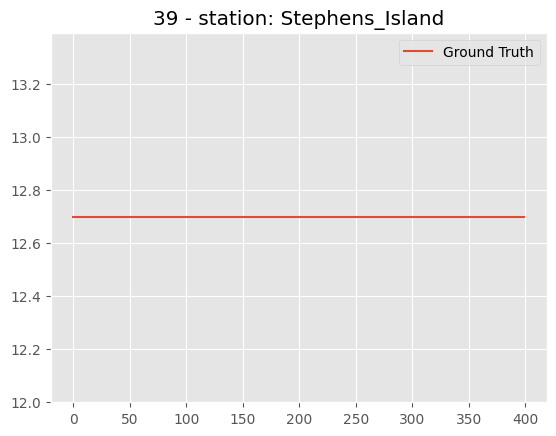

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


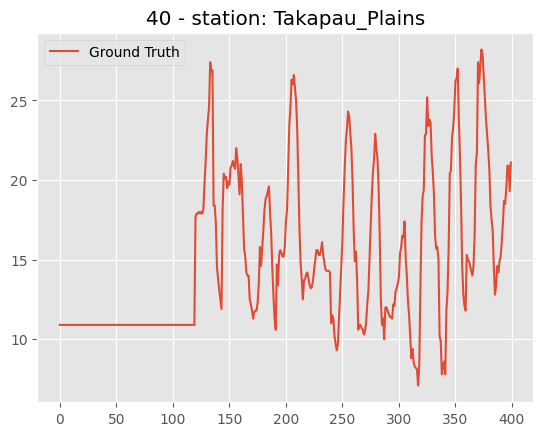

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


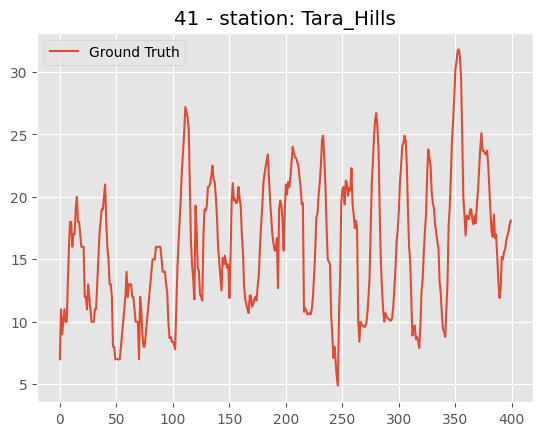

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


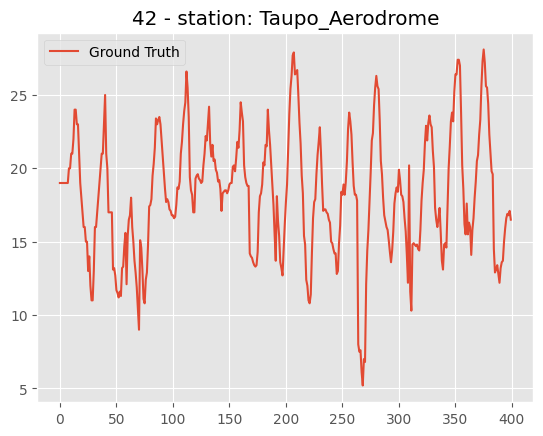

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


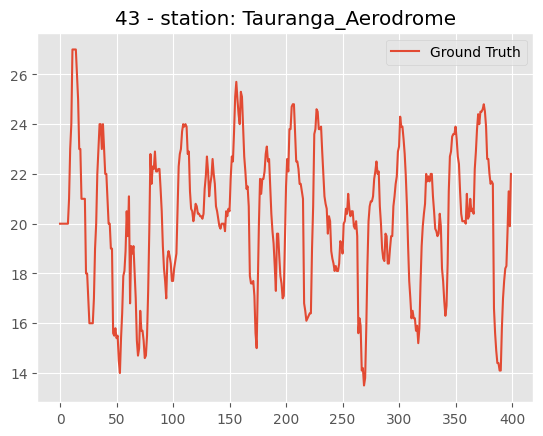

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


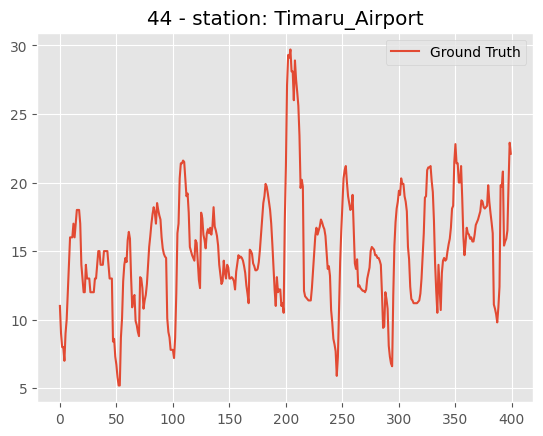

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


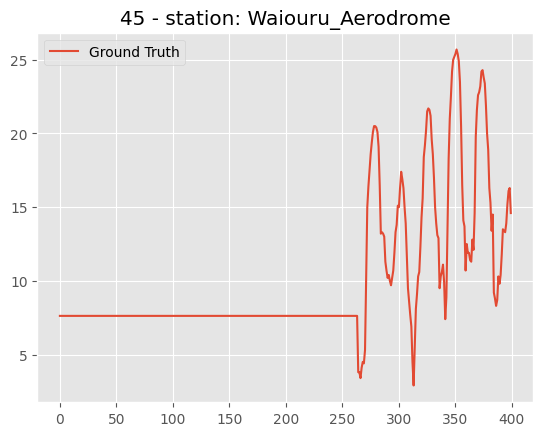

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


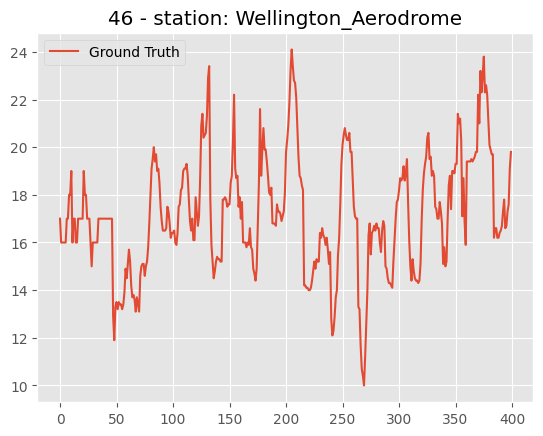

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


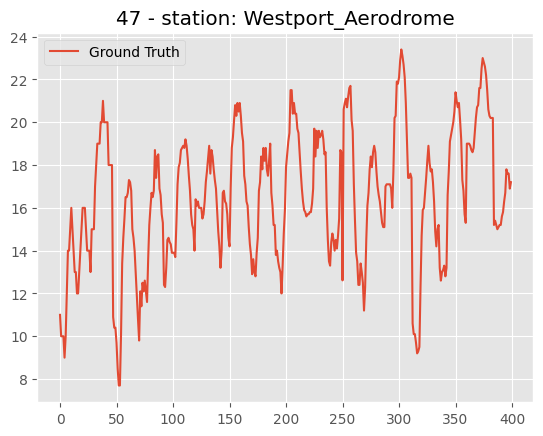

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


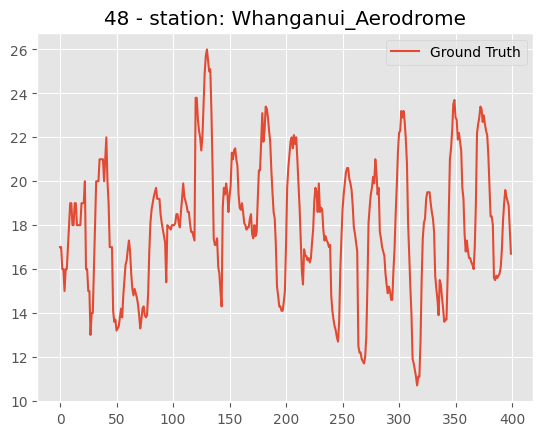

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


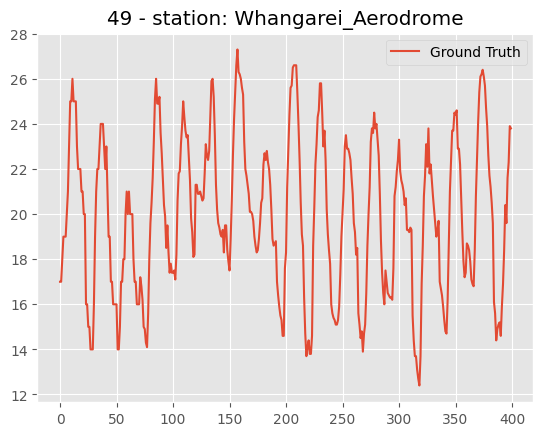

shape idx: 0
shape idx: 99
shape idx: 199
shape idx: 299


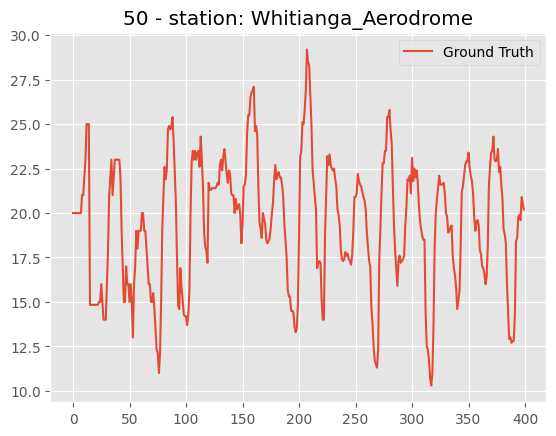

In [55]:
for node in range(51):
    idx = 0
    ytrues = []
    ypreds = []

    for i in range(4):
        print(f"shape idx: {idx}")
        y_true = y_true_src[idx, node,:].tolist()
        y_pred = y_pred_src[idx, node,:].tolist()

        ytrues.extend(y_true)
        ypreds.extend(y_pred)

        idx += 100
        if idx == 100:
            idx -= 1
    plt.title(f"{node} - station: {nodes[node]}")
    plt.plot(ytrues, label="Ground Truth")
    #plt.plot(ypreds, label="Prediction")
    plt.legend()
    plt.show()